In [4]:
!source activate mcfly2
!python -m ipykernel install --user --name mcfly2 --display-name "Python (mcfly2)"

/bin/sh: 1: source: not found
Installed kernelspec mcfly2 in /home/ubuntu/.local/share/jupyter/kernels/mcfly2


In [ ]:
!conda install -c conda-forge keras

Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3

  added / updated specs: 
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scipy-1.0.0                |   py36hbf646e7_0        17.8 MB
    absl-py-0.6.1              |           py36_0         151 KB  conda-forge
    h5py-2.8.0                 |   py36h470a237_0         3.7 MB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    numpy-1.14.2               |   py36hdbf6ddf_0         4.0 MB
    blas-1.0                   |              mkl           6 KB
    ------------------------------------------------------------
                                           Total:        26.4 MB

The following NEW packages will be INSTALLED:

    absl-py:             0.6.1-py36_0               conda-forge
    astor:               0.7.1-py_0               

This notebook loads the data sent by Luca on 01-feb-2018. 

There are two categories: germline SV and somatic SV. 

The windows are centered in any PBJ.

There are 8 channels per window: 4 from the normal cells and 4 from the tumor cells. 

The 4 channels are: exact matches coverage, regural coverage, number of left clips, number of right clips.

Accuracy after one training: 98.6%



## Load dependences and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/mcfly/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [50]:
datapath = '/home/sonja/ChannelMaker_DEL_clipped_win_01022018/'
germline_cube = np.load(datapath + 'germline_cube_data_file.npy')
somatic_cube = np.load(datapath + 'somatic_cube_data_file.npy')
germline_labels = np.load(datapath + 'germline_label_array_file.npy')
somatic_labels = np.load(datapath + 'somatic_label_array_file.npy')

In [51]:
qube_size = germline_cube.shape[0]
                            
germline_cube.shape

(24961, 9, 200)

In [52]:
somatic_cube.shape

(24961, 9, 200)

In [53]:
germline_labels.shape

(24961,)

In [54]:
somatic_labels.shape

(24961,)

Eliminate GC content channel, at the moment it is just noise: 

In [55]:
germline_cube_8channels = germline_cube[:,0:8,:] 
germline_cube_8channels.shape
somatic_cube_8channels = somatic_cube[:,0:8,:]
germline_cube_8channels.shape

(24961, 8, 200)

## Split into training, validation and test datasets

(The numbers should be parameters in the clean version, for now it is OK)

In [56]:
split_training_set = 16000 
split_val_set = 20000
X_train_germline = germline_cube_8channels[0:split_training_set] 
y_train_germline = germline_labels[0:split_training_set]
X_val_germline = germline_cube_8channels[split_training_set:split_val_set]
y_val_germline = germline_labels[split_training_set:split_val_set]
X_test_germline = germline_cube_8channels[split_val_set:qube_size]
y_test_germline = germline_labels[split_val_set:qube_size]

In [57]:
X_train_somatic = somatic_cube_8channels[0:split_training_set]
y_train_somatic = somatic_labels[0:split_training_set]
X_val_somatic = somatic_cube_8channels[split_training_set:split_val_set]
y_val_somatic = somatic_labels[split_training_set:split_val_set]
X_test_somatic = somatic_cube_8channels[split_val_set:qube_size]
y_test_somatic = somatic_labels[split_val_set:qube_size]

In [58]:
X_train = np.concatenate((X_train_germline, X_train_somatic), axis =0)
X_val = np.concatenate((X_val_germline, X_val_somatic), axis =0)
X_test = np.concatenate((X_test_germline, X_test_somatic), axis =0)
y_train = np.concatenate((y_train_germline, y_train_somatic), axis =0)
y_val = np.concatenate((y_val_germline, y_val_somatic), axis =0)
y_test = np.concatenate((y_test_germline, y_test_somatic), axis =0)

In [59]:
X_train.shape

(32000, 8, 200)

In [60]:
X_val.shape

(8000, 8, 200)

In [61]:
X_test.shape

(9922, 8, 200)

In [62]:
number_channels = X_train.shape[1]
number_channels

8

In [63]:
X_train[0]

array([[67, 68, 69, ..., 27, 27, 27],
       [68, 68, 69, ..., 27, 27, 27],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [46, 46, 46, ..., 33, 32, 31],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [64]:
X_train[10000]

array([[62, 60, 60, ..., 29, 29, 28],
       [62, 60, 60, ..., 29, 29, 28],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [64, 64, 64, ..., 31, 30, 30],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [65]:
X_val[0]

array([[27, 26, 25, ..., 33, 34, 34],
       [27, 26, 26, ..., 33, 34, 34],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [29, 29, 29, ..., 38, 37, 36],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [66]:
X_test[0]

array([[32, 33, 33, ..., 56, 56, 55],
       [32, 33, 33, ..., 56, 56, 55],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [25, 25, 25, ..., 60, 60, 60],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [98]:
X_train[15005]

array([[31, 32, 32, ..., 37, 36, 35],
       [31, 32, 32, ..., 37, 36, 35],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [30, 30, 29, ..., 29, 29, 28],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

## Plots several  windows from the germline SV category

In [87]:
n_windows = 30

In [88]:
from numpy import *
import math
import matplotlib.pyplot as plt


def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows):
        print(y_train[i], 'id:', i)
        for j in range (0, number_channels):
            shift = 0
            start = 0
            if j in [0,1,4,5]:
                shift = -60
            if j in [4,5,6,7]:
                start = 70
            Z = [start + shift + x + 5*j*4 for x in X_train[i][j]] 
            plt.ylim([-65,250])
            plt.plot(Z)
        plt.show()

b'germline' id: 15000


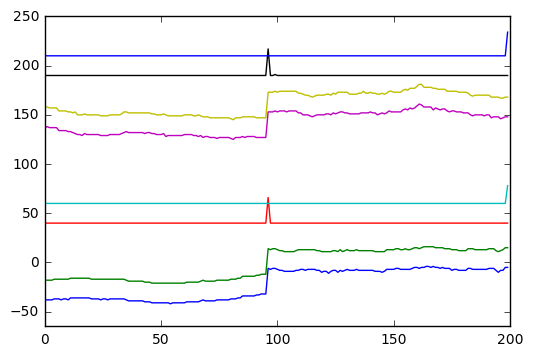

b'germline' id: 15001


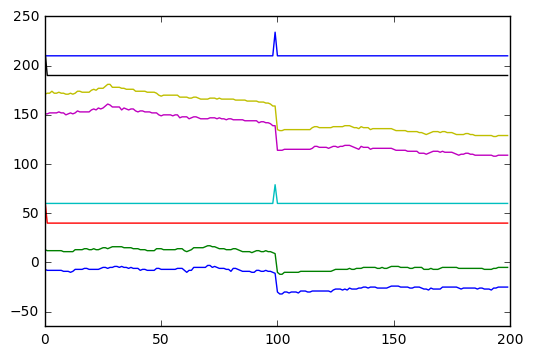

b'germline' id: 15002


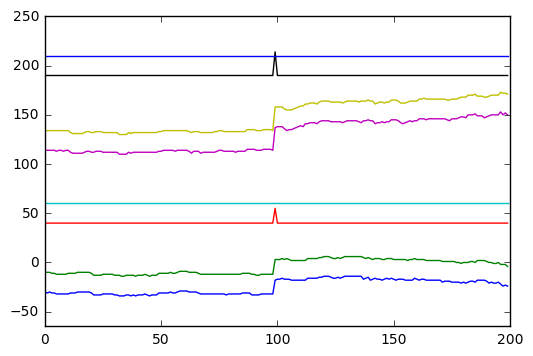

b'germline' id: 15003


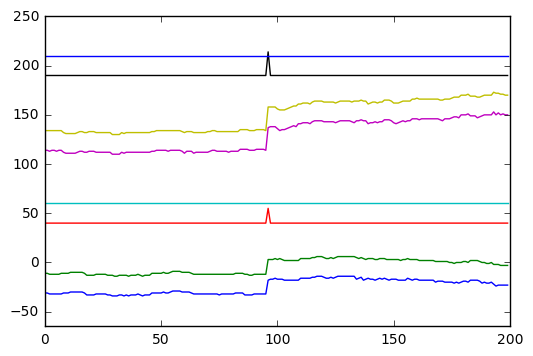

b'germline' id: 15004


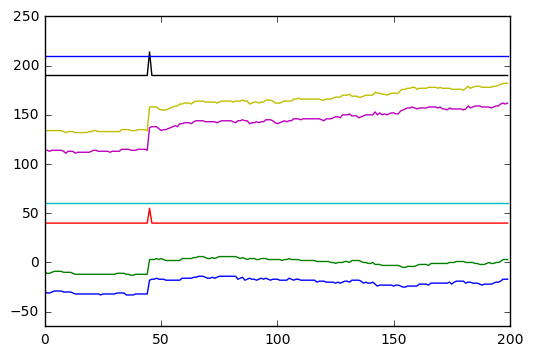

b'germline' id: 15005


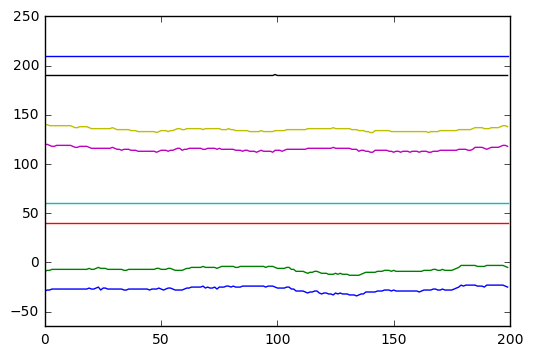

b'germline' id: 15006


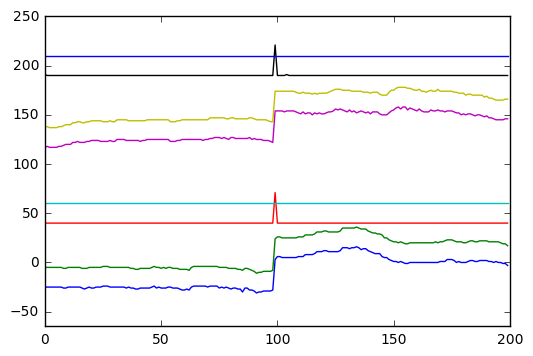

b'germline' id: 15007


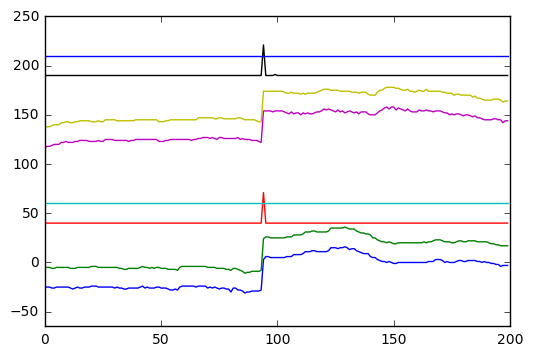

b'germline' id: 15008


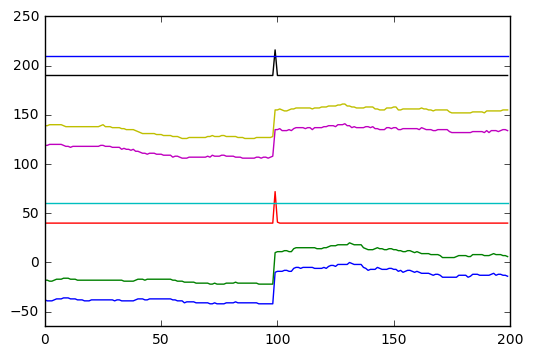

b'germline' id: 15009


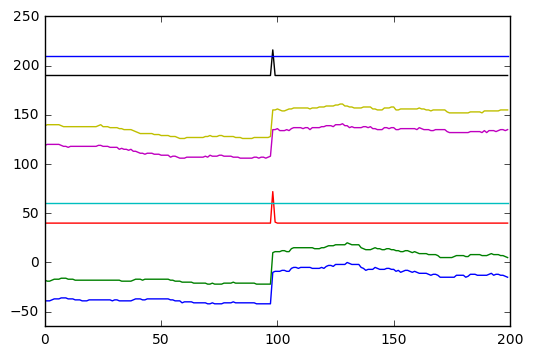

b'germline' id: 15010


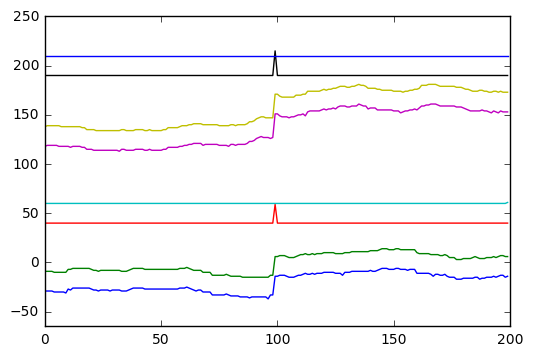

b'germline' id: 15011


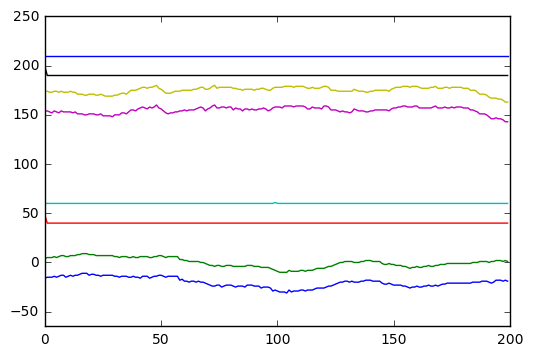

b'germline' id: 15012


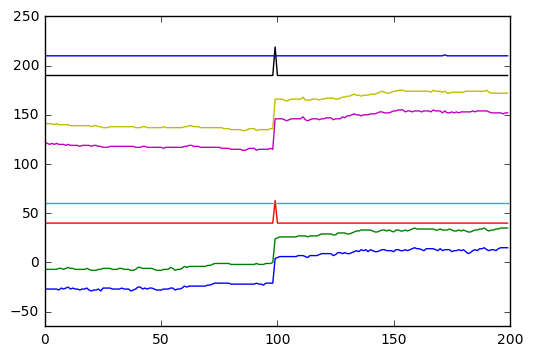

b'germline' id: 15013


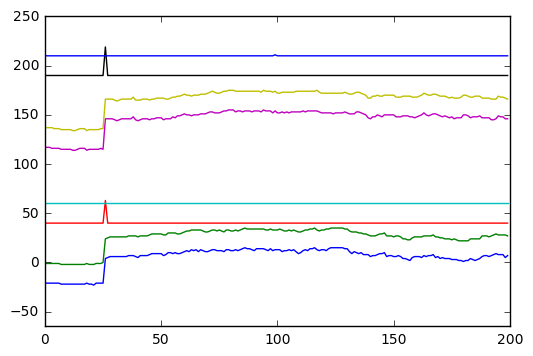

b'germline' id: 15014


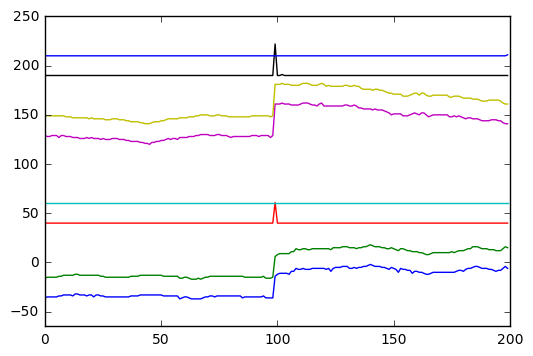

b'germline' id: 15015


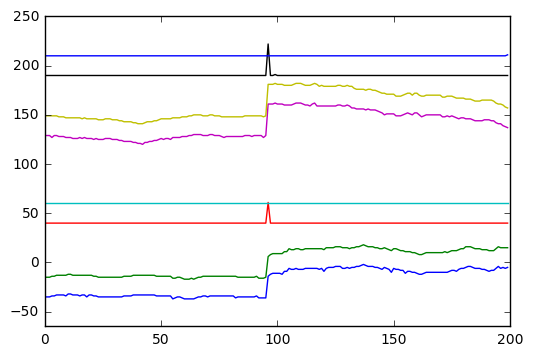

b'germline' id: 15016


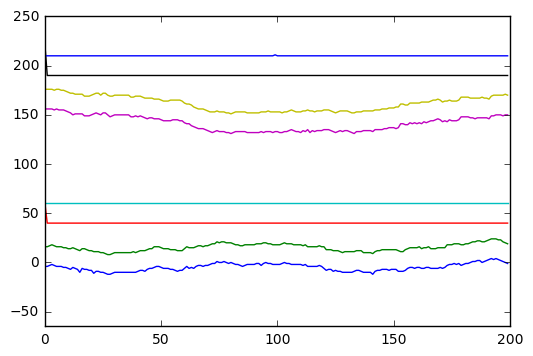

b'germline' id: 15017


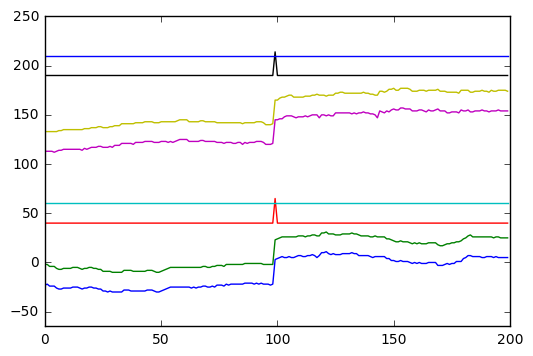

b'germline' id: 15018


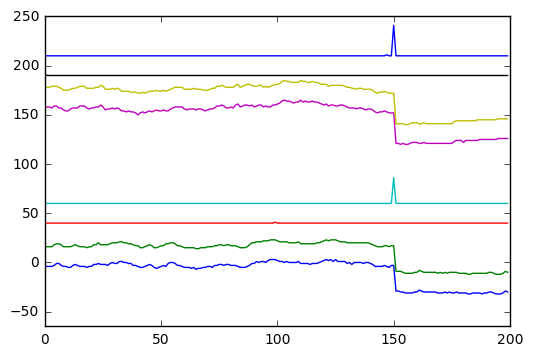

b'germline' id: 15019


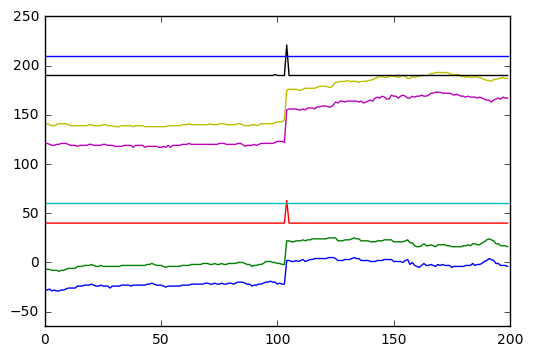

b'germline' id: 15020


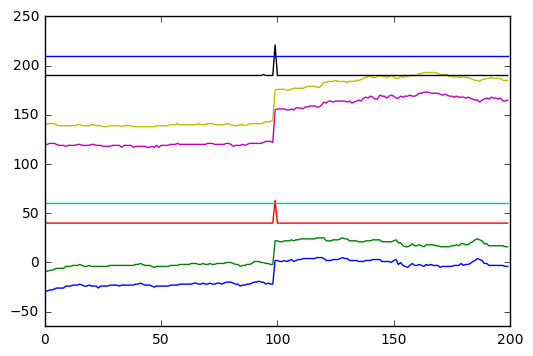

b'germline' id: 15021


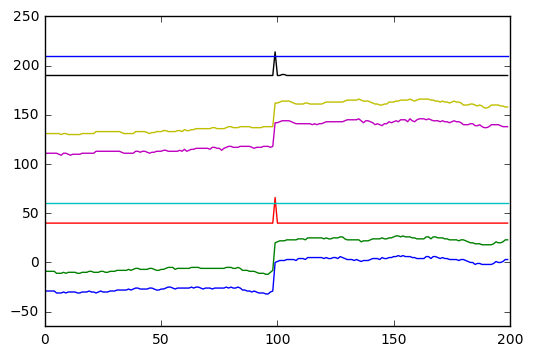

b'germline' id: 15022


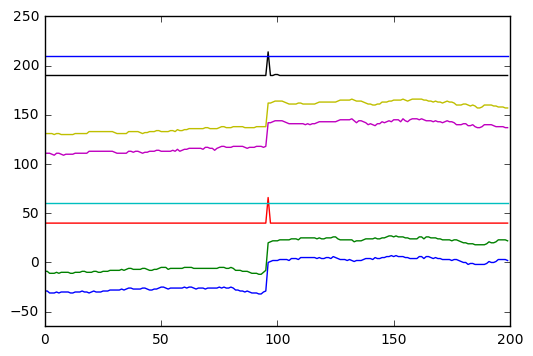

b'germline' id: 15023


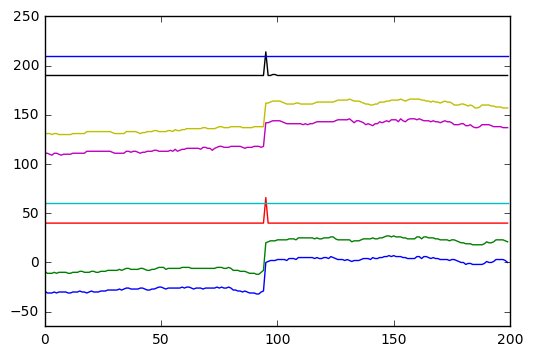

b'germline' id: 15024


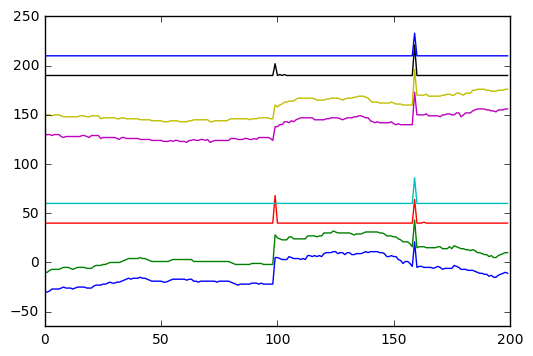

b'germline' id: 15025


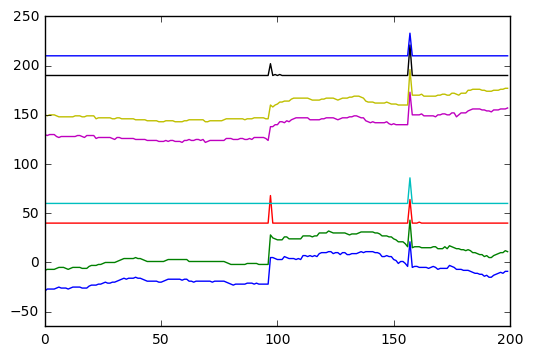

b'germline' id: 15026


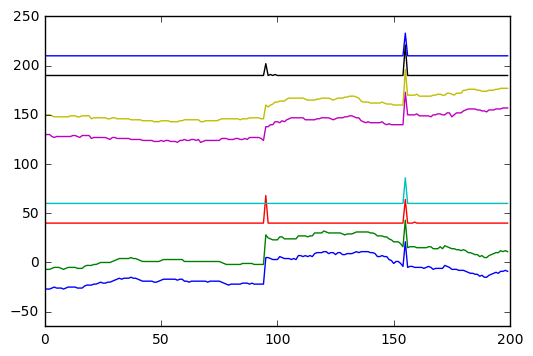

b'germline' id: 15027


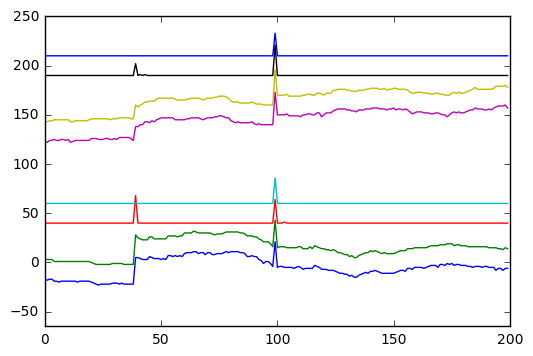

b'germline' id: 15028


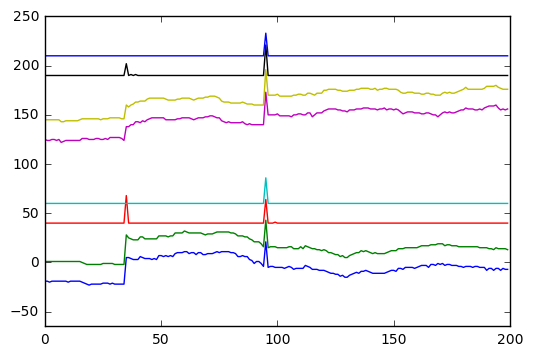

b'germline' id: 15029


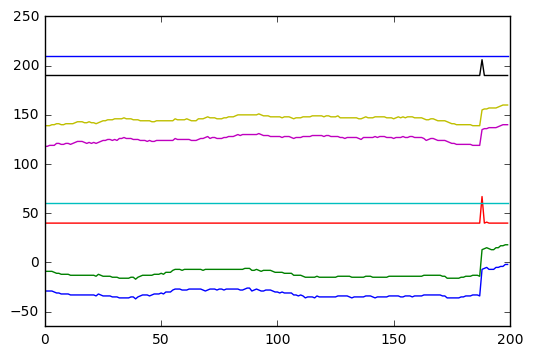

In [89]:
start_window = 15000
plot_channels(start_window, n_windows)

## Plots several windows from the somatic SV category

b'somatic' id: 30000


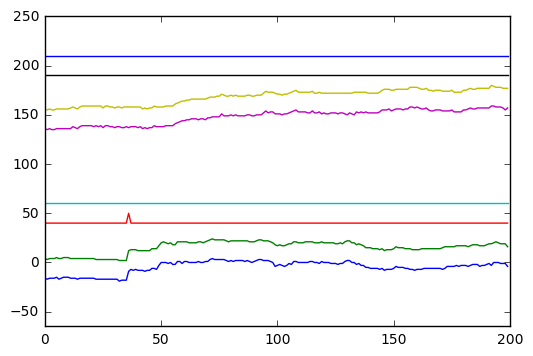

b'somatic' id: 30001


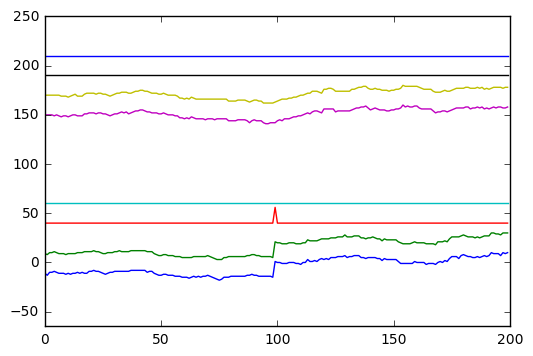

b'somatic' id: 30002


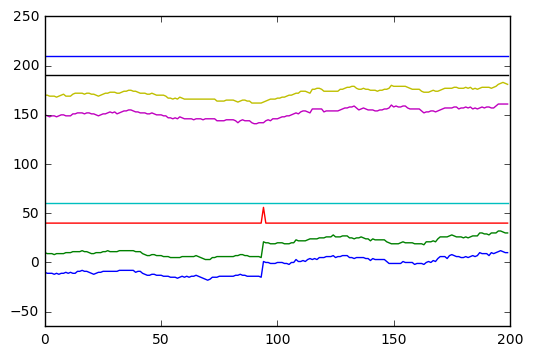

b'somatic' id: 30003


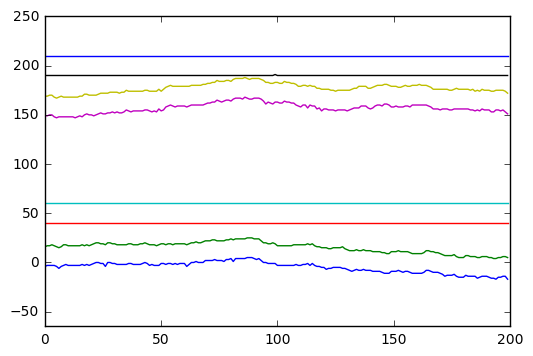

b'somatic' id: 30004


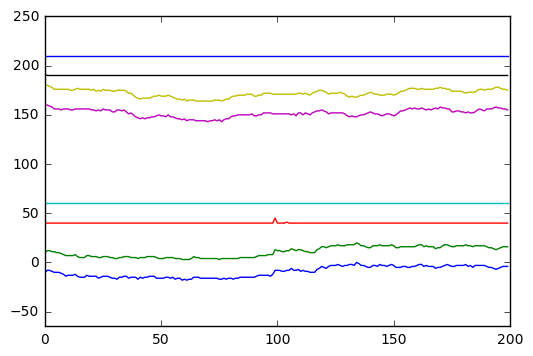

b'somatic' id: 30005


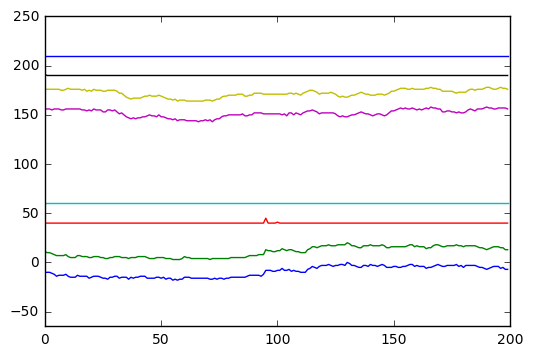

b'somatic' id: 30006


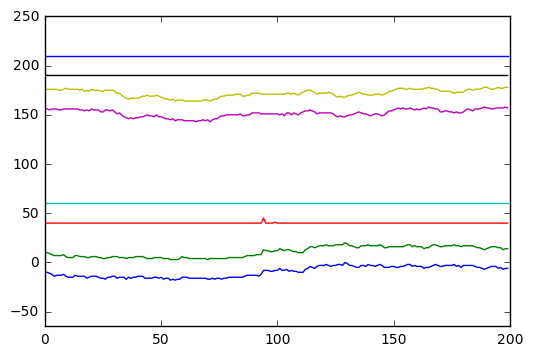

b'somatic' id: 30007


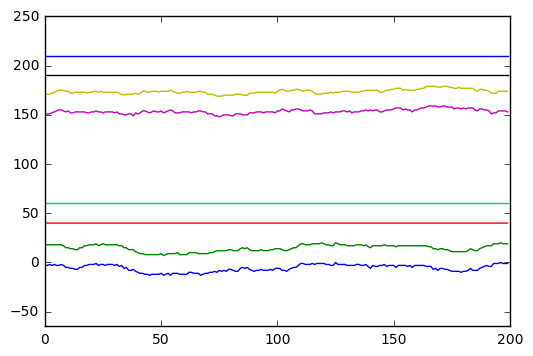

b'somatic' id: 30008


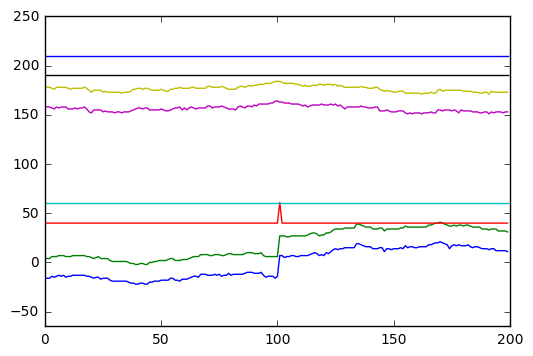

b'somatic' id: 30009


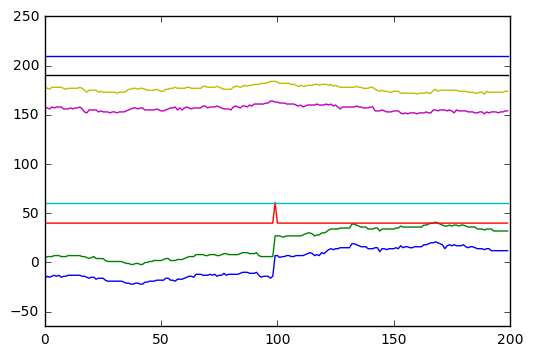

b'somatic' id: 30010


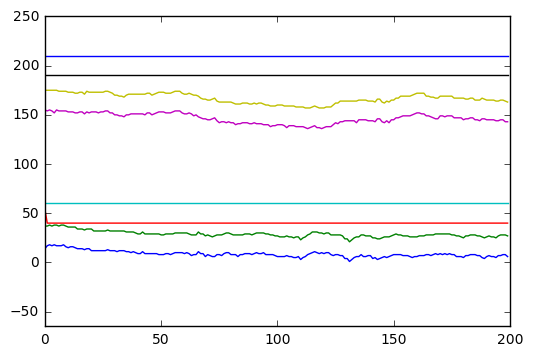

b'somatic' id: 30011


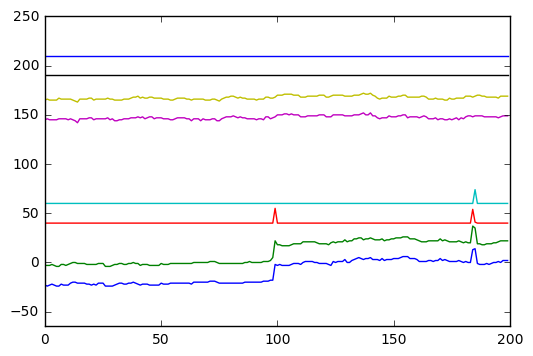

b'somatic' id: 30012


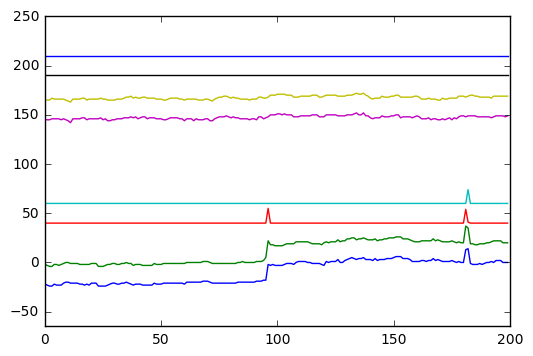

b'somatic' id: 30013


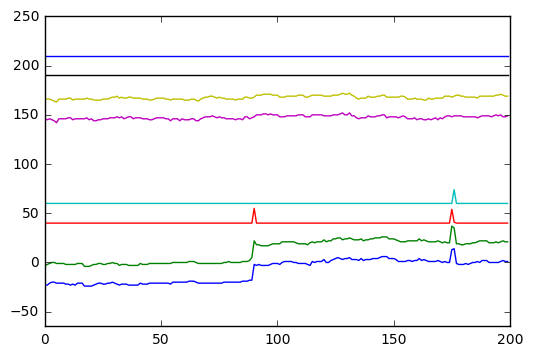

b'somatic' id: 30014


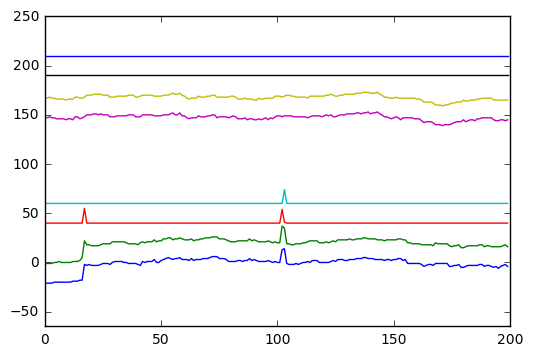

b'somatic' id: 30015


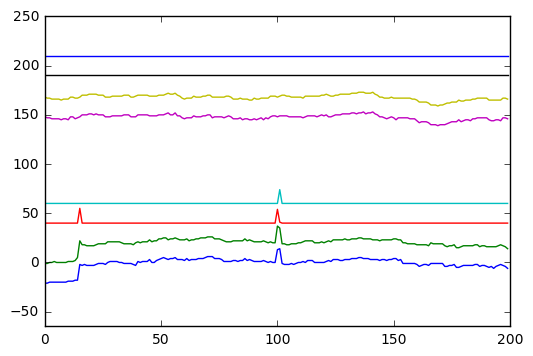

b'somatic' id: 30016


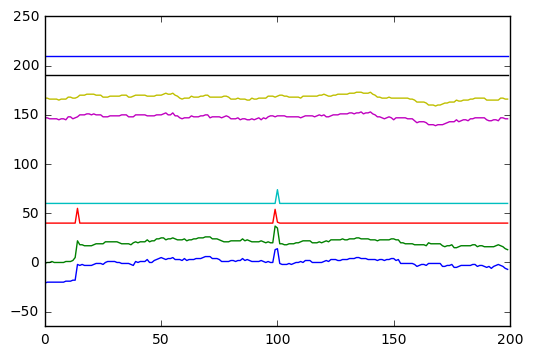

b'somatic' id: 30017


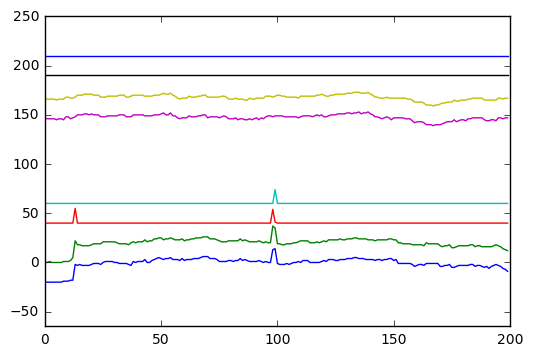

b'somatic' id: 30018


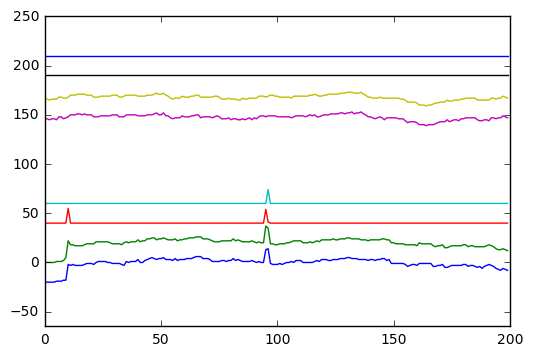

b'somatic' id: 30019


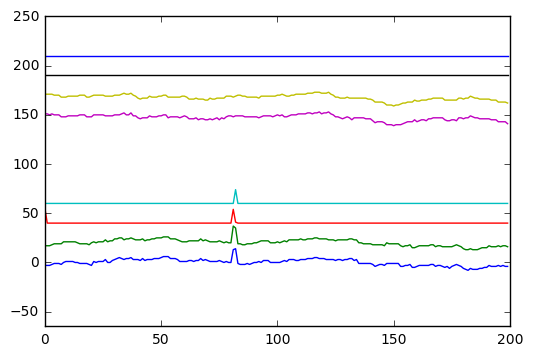

b'somatic' id: 30020


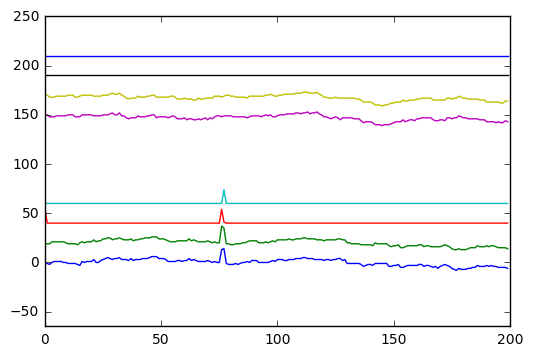

b'somatic' id: 30021


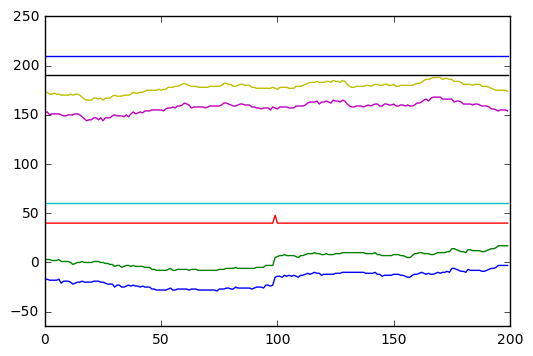

b'somatic' id: 30022


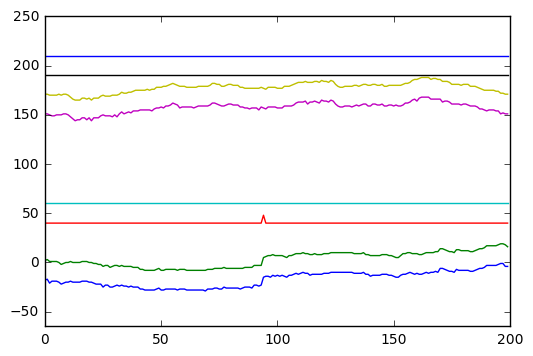

b'somatic' id: 30023


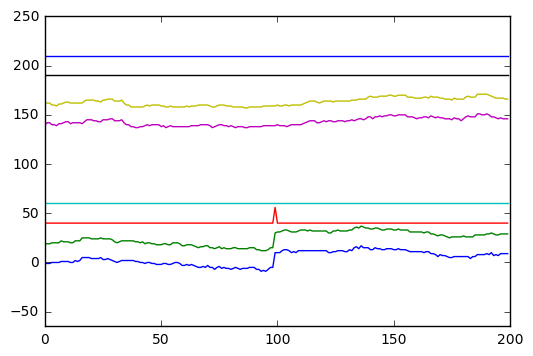

b'somatic' id: 30024


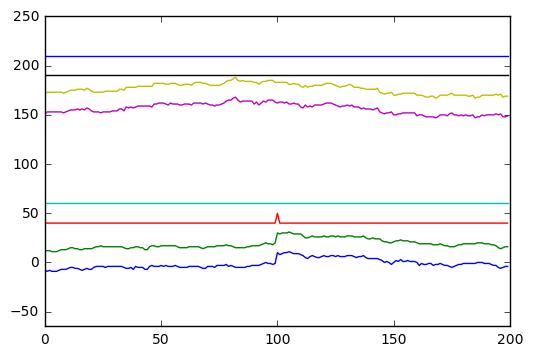

b'somatic' id: 30025


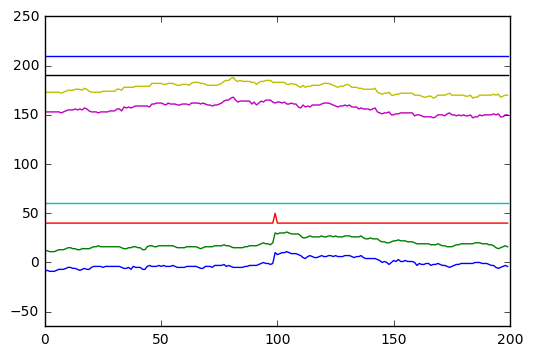

b'somatic' id: 30026


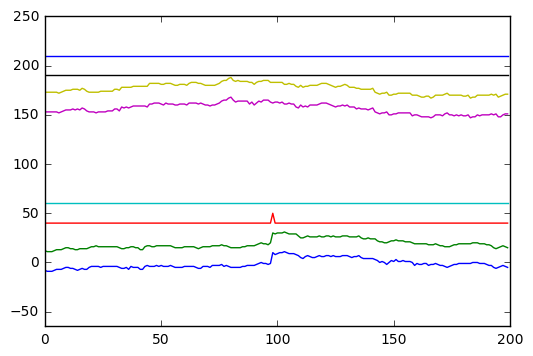

b'somatic' id: 30027


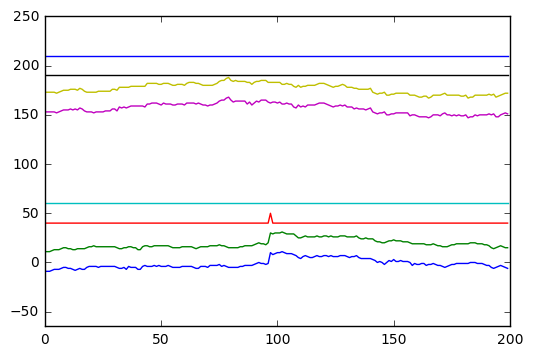

b'somatic' id: 30028


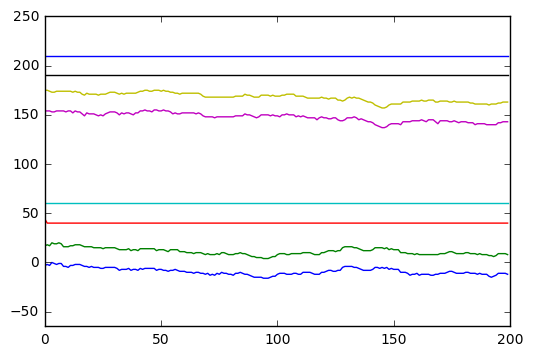

b'somatic' id: 30029


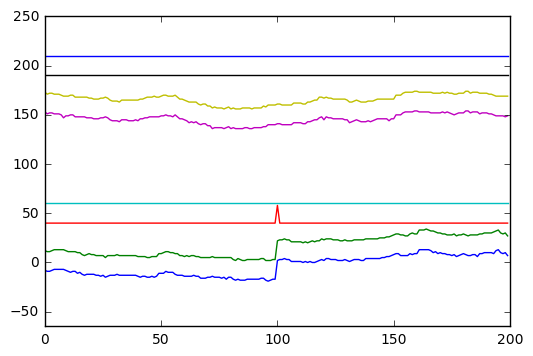

In [99]:

start_window = 30000

plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [22]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

8


## Prepare the labels in McFly format

In [23]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{b'germline': 1, b'somatic': 0}


In [24]:
y_test_binary

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [25]:
y_val_binary

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [26]:
X_train.shape

(32000, 200, 8)

## Generate neural networks architectures

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [28]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [29]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 2,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=2,
                                  cnn_min_fc_nodes=5, 
                                  cnn_max_fc_nodes=15,
                                  low_lr=4, high_lr=8)

CPU times: user 520 ms, sys: 84 ms, total: 604 ms
Wall time: 1.83 s


In [29]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 4.34533240505395e-07, 'filters': array([13, 19, 88]), 'regularization_rate': 0.00015697050209298365, 'fc_hidden_nodes': 14}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_11 (BatchNormali(None, 200, 8)      16          batchnormalization_input_3[0][0] 
____________________________________________________________________________________________________
convolution1d_7 (Convolution1D)    (None, 200, 13)     325         batchnormalization_11[0][0]      
____________________________________________________________________________________________________
batchnormalization_12 (BatchNormali(None, 200, 13)     26          convolution1d_7[0][0]            
____________________________________________________________________________________________________
activation_11 (Activation)         (None, 200, 13)

## Train the networks

In [30]:
train_set_size = X_train.shape[0]
train_set_size

32000

In [31]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5, 
                                                                                  subset_size=train_set_size,
                                                                                  verbose=True)

Training model 0 CNN
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 98s - loss: 2.8125 - acc: 0.8295 - val_loss: 0.5342 - val_acc: 0.7587
Epoch 2/5
32000/32000 [==============================] - 95s - loss: 2.8018 - acc: 0.8366 - val_loss: 0.5078 - val_acc: 0.7872
Epoch 3/5
32000/32000 [==============================] - 103s - loss: 2.7952 - acc: 0.8395 - val_loss: 0.5091 - val_acc: 0.7847
Epoch 4/5
32000/32000 [==============================] - 107s - loss: 2.7836 - acc: 0.8490 - val_loss: 0.5212 - val_acc: 0.7666
Epoch 5/5
32000/32000 [==============================] - 113s - loss: 2.7737 - acc: 0.8541 - val_loss: 0.4945 - val_acc: 0.7962
Training model 1 CNN
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 238s - loss: 0.3591 - acc: 0.9283 - val_loss: 0.2126 - val_acc: 0.9579
Epoch 2/5
32000/32000 [==============================] - 266s - loss: 0.2924 - acc: 0.9662 - v

## Plot training process

Currently run with a very low number of epochs

CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 282 ms


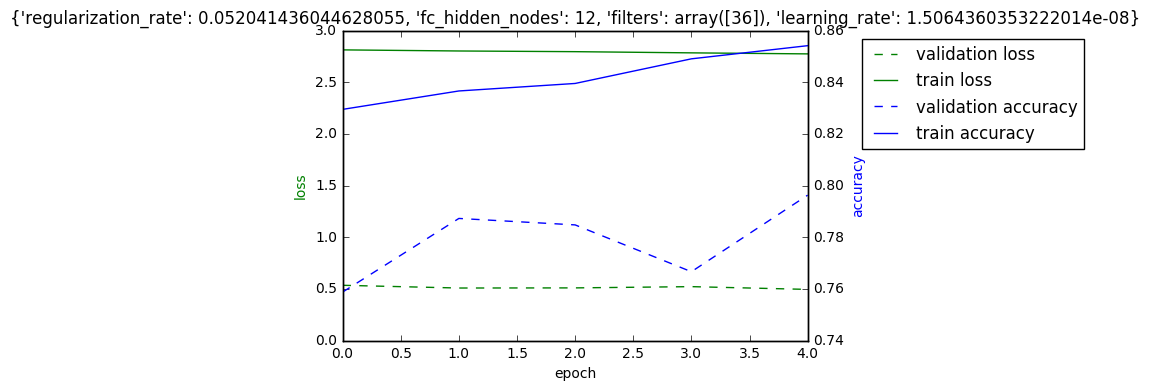

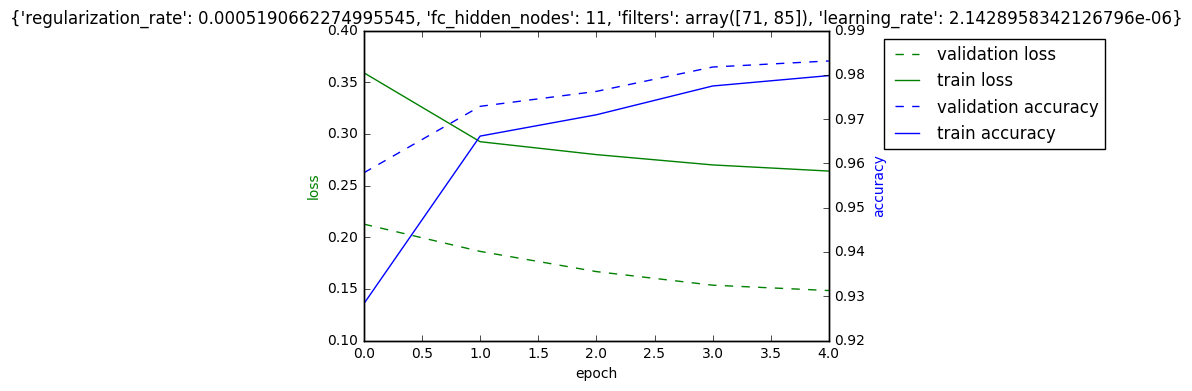

In [32]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [33]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'regularization_rate': 0.052041436044628055, ...",0.854125,2.773715,0.796250,0.494539
1,"{'regularization_rate': 0.0005190662274995545,...",0.979812,0.263967,0.983125,0.148342


## Take the best current model 

In [34]:
best_model_index = np.argmax(val_accuracies)

In [35]:
best_model_index

1

In [36]:
import theano
theano.config.mode

'Mode'

In [37]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'regularization_rate': 0.0005190662274995545, 'fc_hidden_nodes': 11, 'filters': array([71, 85]), 'learning_rate': 2.1428958342126796e-06}


In [38]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'])
best_model_copy = best_model
print(best_model_index, best_model_types, best_params)

1 CNN {'regularization_rate': 0.0005190662274995545, 'fc_hidden_nodes': 11, 'filters': array([71, 85]), 'learning_rate': 2.1428958342126796e-06}


## Save the best current model

In [39]:
from mcfly import storage
name_best_model = 'Gtcg_2_2_2_18_98val'

In [40]:
storage.savemodel(best_model,'/home/sonja/sonja/',name_best_model )

('/home/sonja/sonja/Gtcg_2_2_2_18_98val_architecture.json',
 '/home/sonja/sonja/Gtcg_2_2_2_18_98val_weights')

## Reload the best current model

In [43]:

from mcfly import storage
model_reloaded = storage.loadmodel('/home/sonja/sonja/',name_best_model )
model_reloaded.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(best_params['learning_rate']), 
                  metrics=['accuracy']) 

## Train the best model (not used for now)

## Test best current model on testset

### Overall accuracy on the test set:

In [44]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.14189823352384653, 0.9860915138077001]


### Re-check the train and validation scores: 

In [45]:
best_model.get_config()[0]

{'class_name': 'BatchNormalization',
 'config': {'axis': 2,
  'batch_input_shape': (None, 200, 8),
  'epsilon': 1e-06,
  'input_dtype': 'float32',
  'mode': 0,
  'momentum': 0.9,
  'name': 'batchnormalization_4',
  'trainable': True}}

In [46]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

Train Score of best model: [0.14342058254778386, 0.98684375000000002]


In [47]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))

Val Score of best model: [0.14834248307347297, 0.98312500000000003]
